In [8]:
import jax
import jax.numpy as jnp
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy

# number of paths sampled in one run of calculating dbds. We could handle with parallelization (pmap)
batch_size = 100
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(batch_size)

# currently I'm just doing an SDE on \mathbb{R}
ndims = 1

def sample_sde(b, W, rho, dt, num_steps, key):

    init_key, run_key = jax.random.split(key)
    X_0 = rho(init_key)

    def body(X_and_t, key):
        X, time = X_and_t

        new_X = X + b(X, time) * dt + W(X_0, key) * jnp.sqrt(dt)
        new_time = time + dt
        return ((new_X, new_time), (new_X, new_time))

    keys = jax.random.split(run_key, num_steps-1)
    path, time =  jax.lax.scan(body, (X_0, 0), keys)[1]
    return jnp.concat((X_0[None], path), axis=0), jnp.concat((jnp.zeros(1,), time), axis=0)


In [9]:
hyperparams={'dt': 0.01, 'num_steps': 50, 'num_training_steps' : 1000}


def uref(x, t): 
    potential = lambda x: jnp.sum(x**4 - 8 * x**2,axis=-1)
    return -jax.grad(potential)(x)

path, time = sample_sde(
    b=uref, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-2.,
    key=jax.random.key(0), 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps'])

path[0,0]

Array(-2., dtype=float32)

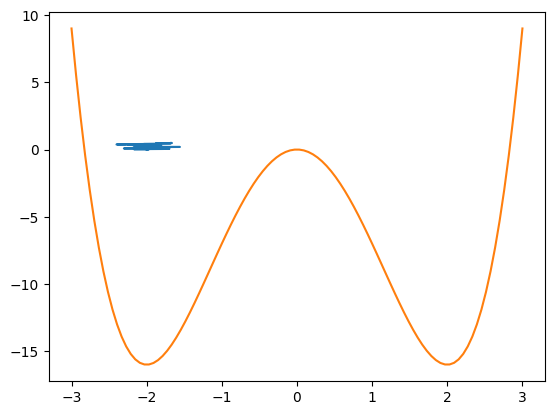

In [10]:
# visualize path
plt.plot(path,time)
# plot potential
potential = lambda x: jnp.sum(x**4 - 8 * x**2,axis=-1)
x = np.linspace(-3, 3, 100)

plt.plot(x, potential(x[:, None]))

In [11]:
# currently set for TPS
def J(x,y):

    # return jax.scipy.stats.norm.pdf(x[-1,0], loc=2, scale=1)
    sigma = 0.1
    return (1/sigma**2)*jnp.linalg.norm(x[-1,0]- 2)**2

    # return (x[-1, :] > 0.).astype(jnp.float32)

def E_J(paths, obs):
    return jnp.mean(jax.vmap(J)(paths, obs),axis=0)


In [12]:

def make_h(b, dbds):

    @jax.jit
    def h(x, time):
        # x: [steps, ndims]
        # time: [steps]

        dt = time[1]
        # TODO: consider whether this treatment of the gradient is correct
        dxdts = jnp.concatenate([jnp.zeros((1, x.shape[1])) , x[1:, :] - x[:-1, :]], axis=0)

        # calculate divergence of dbds at all times, using the trace of the jacobian
        div_dbdss = jax.vmap(lambda xt, t: jnp.trace(jax.jacobian(lambda k: dbds(k,t))(xt)))(x, time)

        # the discretized integral
        out = jax.vmap(lambda x, t, dxdt, div_dbds: 
                    
                    -0.5*dt*((b(x,t) - dxdt).dot(dbds(x,t)) + 0.5*div_dbds)
                    )(x,time, dxdts, div_dbdss)
        
        return jnp.sum(out) 


    return h

# compute the loss function, which here is the square of the difference between the left and right of (7)
def make_h_loss(expectation_of_J, b):
    
    def h_loss(dbds, xs, times, ys):

        h = make_h(b, dbds)

        expectation_of_h = jnp.mean(jax.vmap(h)(xs, times), axis=0)

        # conern: do the two Js cancel under this sum?
        return jnp.sum(jax.vmap(lambda x,y, t: (-J(x, y)+expectation_of_J - h(x,t) + expectation_of_h)**2)(xs, ys, times))

    return h_loss        


In [13]:

# parametrize dbds by a neural net, and minimize h_loss
def find_dbds(model_key, expectation_of_J, b, xs, times, ys, num_training_steps):

    # initialize model
    dbds = MLP([2,20,20,1], key=model_key)
    learning_rate = 1e-3
    optimizer = optax.adam(learning_rate)

    h_loss = make_h_loss(expectation_of_J, b)

    dbds = train(h_loss, dbds, optimizer, num_training_steps, xs, times, ys)

    return dbds


# b \mapsto b + dbds
def update(b, hyperparams, key):

    # b : [ndims] -> [1]

    path_key, model_key = jax.random.split(key)

    xs, times = jax.pmap(lambda key:sample_sde(
    b=b, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.ones((ndims,))-2.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, batch_size))


    plot = True
    if plot:

        x = jnp.expand_dims(jnp.linspace(-5, 5, 100), 1)
        y = (x**4 - 8 * x**2)
        y2 = jax.vmap(lambda k: b(k, 0.1))(x)
        plt.ylim(-15,15)
        plt.plot(x, y)
        plt.plot(xs[0],times[0]*5)
        # plt.hist(xs[0], bins=100, density=True)
        plt.savefig('potential_new.png')

    
    # ys = (xs > 0).astype(jnp.float32)

    expectation_of_J = E_J(xs, None) # .mean(axis=0)


    dbds = find_dbds(
        model_key,
        expectation_of_J,
        b,
        xs,
        times,
        None,
        num_training_steps=hyperparams['num_training_steps']
        )
    

    test_xs, test_times = jax.pmap(lambda key:sample_sde(
        b=b, 
        W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
        rho = lambda key: jnp.zeros((ndims,))-2.,
        key=key, 
        dt=hyperparams['dt'], 
        num_steps=hyperparams['num_steps']))(jax.random.split(jax.random.key(500), batch_size))

    print(make_h_loss(expectation_of_J=expectation_of_J, b=b)(
        dbds,
        test_xs,
        test_times,
        None
    ), "LOSS\n")

    ## TODO: you need to pass in the algorithmic time!!! or not?
    
    new_b =  lambda x, t: (b(x,t) + dbds(x,t))
    

    return new_b

   
# potential = lambda x: jnp.sum(x**4 - 8 * x**2,axis=0)



# def b(x, t): 
#     assert x.shape[0] == ndims
#     return -jax.grad(potential)(x)


# logdensity = todo


loss_value 2509644.5
1849293.4 LOSS

NEXT ITER
loss_value 20557.52734375
14182.863 LOSS

NEXT ITER
loss_value 69433.8046875
72483.52 LOSS

NEXT ITER


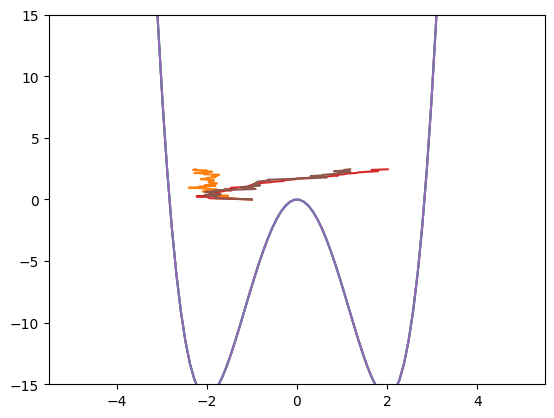

In [14]:
key = jax.random.key(0)
b = uref
schedule = [0.0, 0.1, 0.2] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for i, _ in enumerate(schedule):


    key = jax.random.fold_in(key, i)

    b = update(b=b,
        hyperparams={'dt': 0.01, 'num_steps': 50, 'num_training_steps' : 1000},
        key=key
    )
    print("NEXT ITER")

## Above 

In [6]:

import blackjax

def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform, desired_energy_variance= 5e-4):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda inverse_mass_matrix : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        inverse_mass_matrix=inverse_mass_matrix,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
        desired_energy_var=desired_energy_variance
    )

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )

    # run the sampler
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=True,
    )

    return samples, blackjax_state_after_tuning, blackjax_mclmc_sampler_params, run_key


In [60]:
def I(x, time, u):

    dt = time[1]

    dxdts = jnp.concatenate([jnp.zeros((1,)) , x[1:] - x[:-1]], axis=0)
    print(dxdts.shape)


        # calculate divergence of dbds at all times, using the trace of the jacobian
    div_us = jax.vmap(lambda xt, t: (jax.jacobian(lambda k: u(k,t))(xt)))(x, time)



    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*((dxdt - u(xt, t)).dot(dxdt - u(xt, t))) + 0.5*div_u)(x, time, div_us, dxdts)

    return jnp.sum(out)


In [95]:
hyperparams={'dt': 0.01, 'num_steps': 50, 'num_training_steps' : 1000}
path_key = jax.random.key(0)
xs, times = jax.pmap(lambda key:sample_sde(
    b=b, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, batch_size))

x = xs[0, :, 0]
times[0].shape

# potential = lambda x: (x**4 - 8 * x**2)

schedule = [0.0, 0.1] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


def new_b(x, t): 
    # assert x.shape[0] == ndims
    return -jax.grad(lambda x: (x**4 - 8 * x**2))(x)

# x[0]
# print(new_b(x[0],times[0][0]))

# I(x,times[0], new_b)
-J(jnp.expand_dims(x,1), None)

Array(-19.048677, dtype=float32)

In [101]:
def new_b(x, t): 
    # assert x.shape[0] == ndims
    return -jax.grad(lambda x: (x**4 - 8 * x**2))(x)


time = np.arange(1,hyperparams['num_steps']+1)*hyperparams['dt']
# use onsager machlup here
logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=1) - I(x, time, new_b) - jnp.linalg.norm(x[-1] - 2)**2
# jax.scipy.stats.norm.pdf(x[-1], loc=2, scale=1)

num_steps = 100000
transform = lambda state, info: state.position

hyperparams={'dt': 0.01, 'num_steps': 50, 'num_training_steps' : 1000}
path_key = jax.random.key(0)
xs, times = jax.pmap(lambda key:sample_sde(
    b=b, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, batch_size))

initial_position = xs[0, :, 0]

# print(initial_position.shape)
# raise Exception

rng_key = jax.random.PRNGKey(0)
sample_key, rng_key = jax.random.split(rng_key)
samples, initial_state, params, chain_key = run_mclmc(
    logdensity_fn=logdensity_fn,
    num_steps=num_steps,
    initial_position=initial_position,
    key=sample_key,
    transform=transform,
)

print(samples.shape)



(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)


(100000, 50)


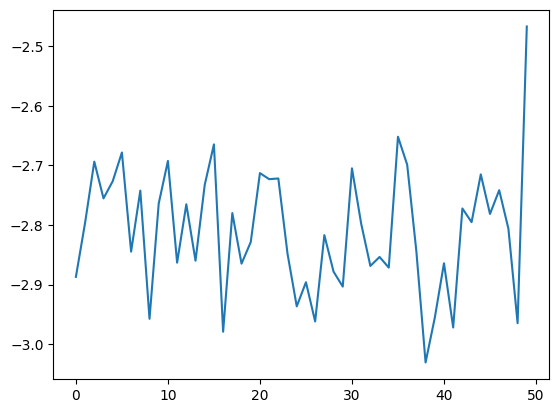

In [102]:
# plot samples[-1]
samples.shape
plt.plot(samples[0, :])